<a href="https://colab.research.google.com/github/Aniket1492/PdfML/blob/main/MainInvoicingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.flush_and_unmount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [1]:
!pip install transformers[torch]


In [2]:
!pip install accelerate -U

In [3]:
!sudo apt install -y tesseract-ocr
!pip install pytesseract transformers datasets seqeval tensorboard evaluate --upgrade


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [4]:
#!/bin/bash
IOB_DATA_PATH = "/content/Annotation3_kVgqzKt.zip"
!cd /content/


In [5]:
!pwd

/content


In [6]:
! rm -r data
! mkdir data


rm: cannot remove 'data': No such file or directory


In [7]:
! cp "$IOB_DATA_PATH" data/dataset.zip


In [8]:
!pwd

/content


In [9]:
! cd data && unzip -q dataset && rm dataset.zip
! cd ..

In [10]:
!pwd

/content


In [11]:
#!/bin/bash
#preprocessing args
TEST_SIZE = 0.33
DATA_OUTPUT_PATH = "/content/"

In [12]:
%%writefile ./preprocess.py

import pandas as pd
import numpy as np
import os
import argparse
from datasets.features import ClassLabel
from transformers import AutoProcessor
from sklearn.model_selection import train_test_split
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D, Dataset
from datasets import Image as Img
from PIL import Image

import warnings
warnings.filterwarnings('ignore')


def read_text_file(file_path):
    with open(file_path, 'r') as f:
        return (f.readlines())


def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

def get_zip_dir_name():
    try:
        os.chdir('/content/data')
        print("in zip function ===========================")

        dir_list = os.listdir()
        print(dir_list)

        any_file_name = dir_list[0]
        print(any_file_name)

        zip_dir_name = any_file_name[:any_file_name.find("\\")]
        print("in function =====================================")

        print(zip_dir_name)
        print("in lamda =====================================")
        print(all(list(map(lambda x: 'A'+ x, dir_list))))

        if all(list(map(lambda x: x.startswith(zip_dir_name), dir_list))):
            return zip_dir_name
        return False
    finally:
        os.chdir('./../')


def filter_out_unannotated(example):
    tags = example['ner_tags']
    return not all([tag == label2id['O'] for tag in tags])



if __name__ == '__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument('--valid_size')
    parser.add_argument('--output_path')
    args = parser.parse_args()
    TEST_SIZE = float(args.valid_size)
    OUTPUT_PATH = args.output_path

    os.makedirs(args.output_path, exist_ok=True)
    files = {}
    zip_dir_name = get_zip_dir_name()

    print(zip_dir_name)
    print(os.path.join( os.curdir, 'data', f'{zip_dir_name}\\{zip_dir_name}_box.txt'))
    if zip_dir_name:
        files['train_box'] = read_text_file(os.path.join(
            os.curdir, 'data', f'{zip_dir_name}\\{zip_dir_name}_box.txt'))
        files['train_image'] = read_text_file(os.path.join(
            os.curdir, 'data', f'{zip_dir_name}\\{zip_dir_name}_image.txt'))
        files['train'] = read_text_file(os.path.join(
            os.curdir, 'data', f'{zip_dir_name}\\{zip_dir_name}.txt'))

    else:
        os.chdir('/content/data')
        print("in else ==================================================")
        print(os.listdir())
        for f in os.listdir():
            print(f)
            print(f.endswith('.txt'))
            print(f.find('box'))
            if f.endswith('.txt') and f.find('box') != -1:
                files['train_box'] = read_text_file(os.path.join(os.curdir, f))
            elif f.endswith('.txt') and f.find('image') != -1:
                files['train_image'] = read_text_file(
                    os.path.join(os.curdir, f))
            elif f.endswith('.txt') and f.find('labels') == -1:
                files['train'] = read_text_file(os.path.join(os.curdir, f))

    assert(len(files['train']) == len(files['train_box']))
    assert(len(files['train_box']) == len(files['train_image']))
    assert(len(files['train_image']) == len(files['train']))

    images = {}
    for i, row in enumerate(files['train_image']):
        if row != '\n':
            image_name = row.split('\t')[-1]
            images.setdefault(image_name.replace('\n', ''), []).append(i)

    words, bboxes, ner_tags, image_path = [], [], [], []
    for image, rows in images.items():
        words.append([row.split('\t')[0].replace('\n', '')
                     for row in files['train'][rows[0]:rows[-1]+1]])
        ner_tags.append([row.split('\t')[1].replace('\n', '')
                        for row in files['train'][rows[0]:rows[-1]+1]])
        bboxes.append([box.split('\t')[1].replace('\n', '')
                      for box in files['train_box'][rows[0]:rows[-1]+1]])
        if zip_dir_name:
            image_path.append(f"/content/data/{zip_dir_name}\\{image}")
        else:
            image_path.append(f"/content/data/{image}")

    labels = list(set([tag for doc_tag in ner_tags for tag in doc_tag]))
    id2label = {v: k for v, k in enumerate(labels)}
    label2id = {k: v for v, k in enumerate(labels)}

    dataset_dict = {
        'id': range(len(words)),
        'tokens': words,
        'bboxes': [[list(map(int, bbox.split())) for bbox in doc] for doc in bboxes],
        'ner_tags': [[label2id[tag] for tag in ner_tag] for ner_tag in ner_tags],
        'image': [Image.open(path).convert("RGB") for path in image_path]
    }

    #raw features
    features = Features({
        'id': Value(dtype='string', id=None),
        'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
        'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
        'ner_tags': Sequence(feature=ClassLabel(num_classes=len(labels), names=labels, names_file=None, id=None), length=-1, id=None),
        'image': Img(decode=True, id=None)
    })

    full_data_set = Dataset.from_dict(dataset_dict, features=features)
    dataset = full_data_set.train_test_split(test_size=TEST_SIZE)
    dataset["train"] = dataset["train"].filter(filter_out_unannotated)
    processor = AutoProcessor.from_pretrained(
        "microsoft/layoutlmv3-base", apply_ocr=False)

    features = dataset["train"].features
    column_names = dataset["train"].column_names
    image_column_name = "image"
    text_column_name = "tokens"
    boxes_column_name = "bboxes"
    label_column_name = "ner_tags"

    features = Features({
        'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
        'input_ids': Sequence(feature=Value(dtype='int64')),
        'attention_mask': Sequence(Value(dtype='int64')),
        'bbox': Array2D(dtype="int64", shape=(512, 4)),
        'labels': Sequence(ClassLabel(names=labels)),
    })

    train_dataset = dataset["train"].map(
        prepare_examples,
        batched=True,
        remove_columns=column_names,
        features=features,
    )
    eval_dataset = dataset["test"].map(
        prepare_examples,
        batched=True,
        remove_columns=column_names,
        features=features,
    )
    train_dataset.set_format("torch")
    if not OUTPUT_PATH.endswith('/'):
        OUTPUT_PATH += '/'
    train_dataset.save_to_disk(f'{OUTPUT_PATH}train_split')
    eval_dataset.save_to_disk(f'{OUTPUT_PATH}eval_split')
    dataset.save_to_disk(f'{OUTPUT_PATH}raw_data')

Writing ./preprocess.py


In [13]:

## Running Preprocessing script
!python3 /content/preprocess.py --valid_size $TEST_SIZE --output_path $DATA_OUTPUT_PATH

2024-03-30 13:45:58.067868: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 13:45:58.068023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 13:45:58.241091: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-30 13:46:01.480894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
in zip function ===========================
['resized_outfile_5_image_0.jpg', 'resized_outfile_3_image_0.jpg', 'e7a7aa88-3d75-40c8-9a99-fdeaa2b56bdb.txt', 'resized_outfile_6_image_0.jpg', 'e7a7aa88-3d75-40c8-9a99-fdeaa2b56bdb_labels.txt', 'e

In [14]:
from datasets import load_metric
from transformers import TrainingArguments, Trainer
from transformers import LayoutLMv3ForTokenClassification,AutoProcessor
from transformers.data.data_collator import default_data_collator
import torch

In [15]:
# load datasets
from datasets import load_from_disk
train_dataset = load_from_disk(f'/content/train_split')
eval_dataset = load_from_disk(f'/content/eval_split')

In [16]:
## Loading raw dataset without Encoding or applying feature extractor
train_raw_dataset = load_from_disk(f'/content/raw_data/train')
eval_raw_dataset = load_from_disk(f'/content/raw_data/test')

In [17]:
train_raw_dataset

Dataset({
    features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
    num_rows: 2
})

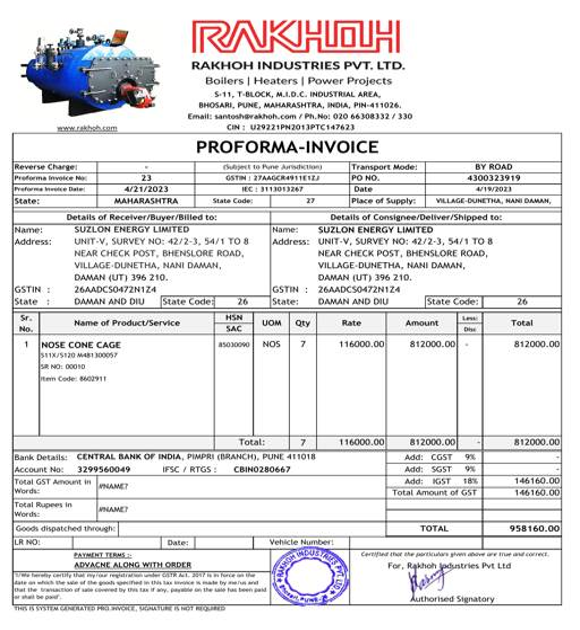

In [76]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/test_images/resized_outfile_3_image_0.jpg")
image = image.convert("RGB")
image.resize((580,630))

In [77]:
label_list = train_dataset.features["labels"].feature.names
num_labels = len(label_list)
label2id, id2label = dict(), dict()
for i, label in enumerate(label_list):
    label2id[label] = i
    id2label[i] = label

In [78]:
from transformers import LiltForTokenClassification

# huggingface hub model id
model_id = "SCUT-DLVCLab/lilt-roberta-en-base"

# load model with correct number of labels and mapping
model = LiltForTokenClassification.from_pretrained(
    model_id, num_labels=len(label_list), label2id=label2id, id2label=id2label
)

Some weights of LiltForTokenClassification were not initialized from the model checkpoint at SCUT-DLVCLab/lilt-roberta-en-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
print(model)

LiltForTokenClassification(
  (lilt): LiltModel(
    (embeddings): LiltTextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layout_embeddings): LiltLayoutEmbeddings(
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
      (box_position_embeddings): Embedding(514, 192, padding_idx=1)
      (box_linear_embeddings): Linear(in_features=768, out_features=192, bias=True)
      (LayerNorm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LiltEncoder(
      (layer): ModuleList(
        (0-11): 12 x Lil

In [23]:
metric = load_metric("seqeval")
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels,zero_division='0')
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

<ipython-input-23-85fe06d7c113>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [94]:
from transformers import Trainer, TrainingArguments
NUM_TRAIN_EPOCHS = 100
PER_DEVICE_TRAIN_BATCH_SIZE = 3
PER_DEVICE_EVAL_BATCH_SIZE = 3
LEARNING_RATE = 4e-5
training_args = TrainingArguments(output_dir="LiLT_INVOICE",
                                  # max_steps=1500,
                                  num_train_epochs=NUM_TRAIN_EPOCHS,
                                  logging_strategy="epoch",
                                  save_total_limit=1,
                                  per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
                                  per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
                                  learning_rate=LEARNING_RATE,
                                  evaluation_strategy="no",
                                  save_strategy="no",
                                  # eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)


In [95]:
import gc
torch.cuda.empty_cache()
gc.collect()

58

In [96]:
# Start training
trainer.train()

Step,Training Loss
1,0.000500
2,0.001000
3,0.000900
4,0.005400
5,0.000700
6,0.000800
7,0.001400
8,0.001200
9,0.001300
10,0.000800


TrainOutput(global_step=100, training_loss=0.0004944493391667493, metrics={'train_runtime': 1591.716, 'train_samples_per_second': 0.126, 'train_steps_per_second': 0.063, 'total_flos': 55649566924800.0, 'train_loss': 0.0004944493391667493, 'epoch': 100.0})

In [97]:
trainer.evaluate()

{'eval_loss': 3.5930745601654053,
 'eval_precision': 0.2727272727272727,
 'eval_recall': 0.21951219512195122,
 'eval_f1': 0.24324324324324323,
 'eval_accuracy': 0.5346938775510204,
 'eval_runtime': 2.6131,
 'eval_samples_per_second': 0.383,
 'eval_steps_per_second': 0.383,
 'epoch': 100.0}

In [98]:
trainer.save_model('/content/LiLTmodel1')

In [99]:
from transformers import LiltForTokenClassification, LayoutLMv3Processor
from transformers import LayoutLMv3FeatureExtractor, AutoTokenizer, LayoutLMv3Processor
from PIL import Image, ImageDraw, ImageFont
import torch

# load model and processor from huggingface hub
model = LiltForTokenClassification.from_pretrained("/content/LiLTmodel1")


model_id="SCUT-DLVCLab/lilt-roberta-en-base"

# use LayoutLMv3 processor without ocr since the dataset already includes the ocr text
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=True) # set
tokenizer = AutoTokenizer.from_pretrained(model_id)
# cannot use from_pretrained since the processor is not saved in the base model
processor = LayoutLMv3Processor(feature_extractor, tokenizer)



# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

# helper function to unnormalize bboxes for drawing onto the image


label2color = {
 'B-VENDOR ADDRESS':"violet",
 'B-VENDOR NAME':"tan",
 'E-VENDOR ADDRESS':"violet",
 'E-VENDOR NAME':"tan",
 'I-VENDOR ADDRESS':"violet",
 'I-VENDOR NAME':"tan",
 'B-SHIP TO ADDRESS' :"blue",
 'B-SHIP TO NAME':"orange",
 'E-SHIP TO ADDRESS':"blue",
 'E-SHIP TO NAME':"orange",
 'I-SHIP TO ADDRESS':"blue",
 'I-SHIP TO NAME':"orange",
 'B-INVOICE DATE':"yellow",
 'E-INVOICE DATE':"yellow",
 'I-INVOICE DATE':"yellow",
 'S-INVOICE DATE':"yellow",
 'B-INVOICE DESCRIPTION':"green",
 'E-INVOICE DESCRIPTION':"green",
 'S-INVOICE DESCRIPTION':"green",
 'B-INVOICE NUMBER':"cyan",
 'E-INVOICE NUMBER':"cyan",
 'S-INVOICE NUMBER':"cyan",
 'S-INVOICE TOTAL':"purple",
 'B-ITEM':"pink",
 'E-ITEM':"pink",
 'I-ITEM':"pink",
 'S-LINETOTAL':"brown",
 'S-PO DATE':"fuchsia",
 'S-PONUMBER':"magenta",
 'S-QUANTITY':"lime",
 'S-TAX AMOUNT':"peru",
 'S-UOM':"grey",
 'O':"red",
 'B-II':"firebrick",
 'E-II':"firebrick",
 'I-II':"firebrick",
 'B-SI':"salmon",
 'E-SI':"salmon",
 'I-SI':"salmon",
 'B-TI':"coral",
 'E-TI':"coral",
 'I-TI':"coral",
 'B-VI':"olive",
 'E-VI':"olive",
 'I-VI':"olive"
}

# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


# run inference
def run_inference(image, model=model, processor=processor, output_image=True):
    # create model input
    encoding = processor(image, return_tensors="pt")
    del encoding["pixel_values"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels






/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv3/feature_extraction_layoutlmv3.py:30: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  warnings.warn(


In [100]:
image_cropped=Image.open("/content/test_images/resized_outfile_3_image_0.jpg")
image_cropped.crop((152.5400, 121.5900, 220.9800, 130.4100))
#image_cropped=image.crop((0,   0,  34,  63))
#image_cropped = image_cropped.save("/content/Cropped_test1.png")

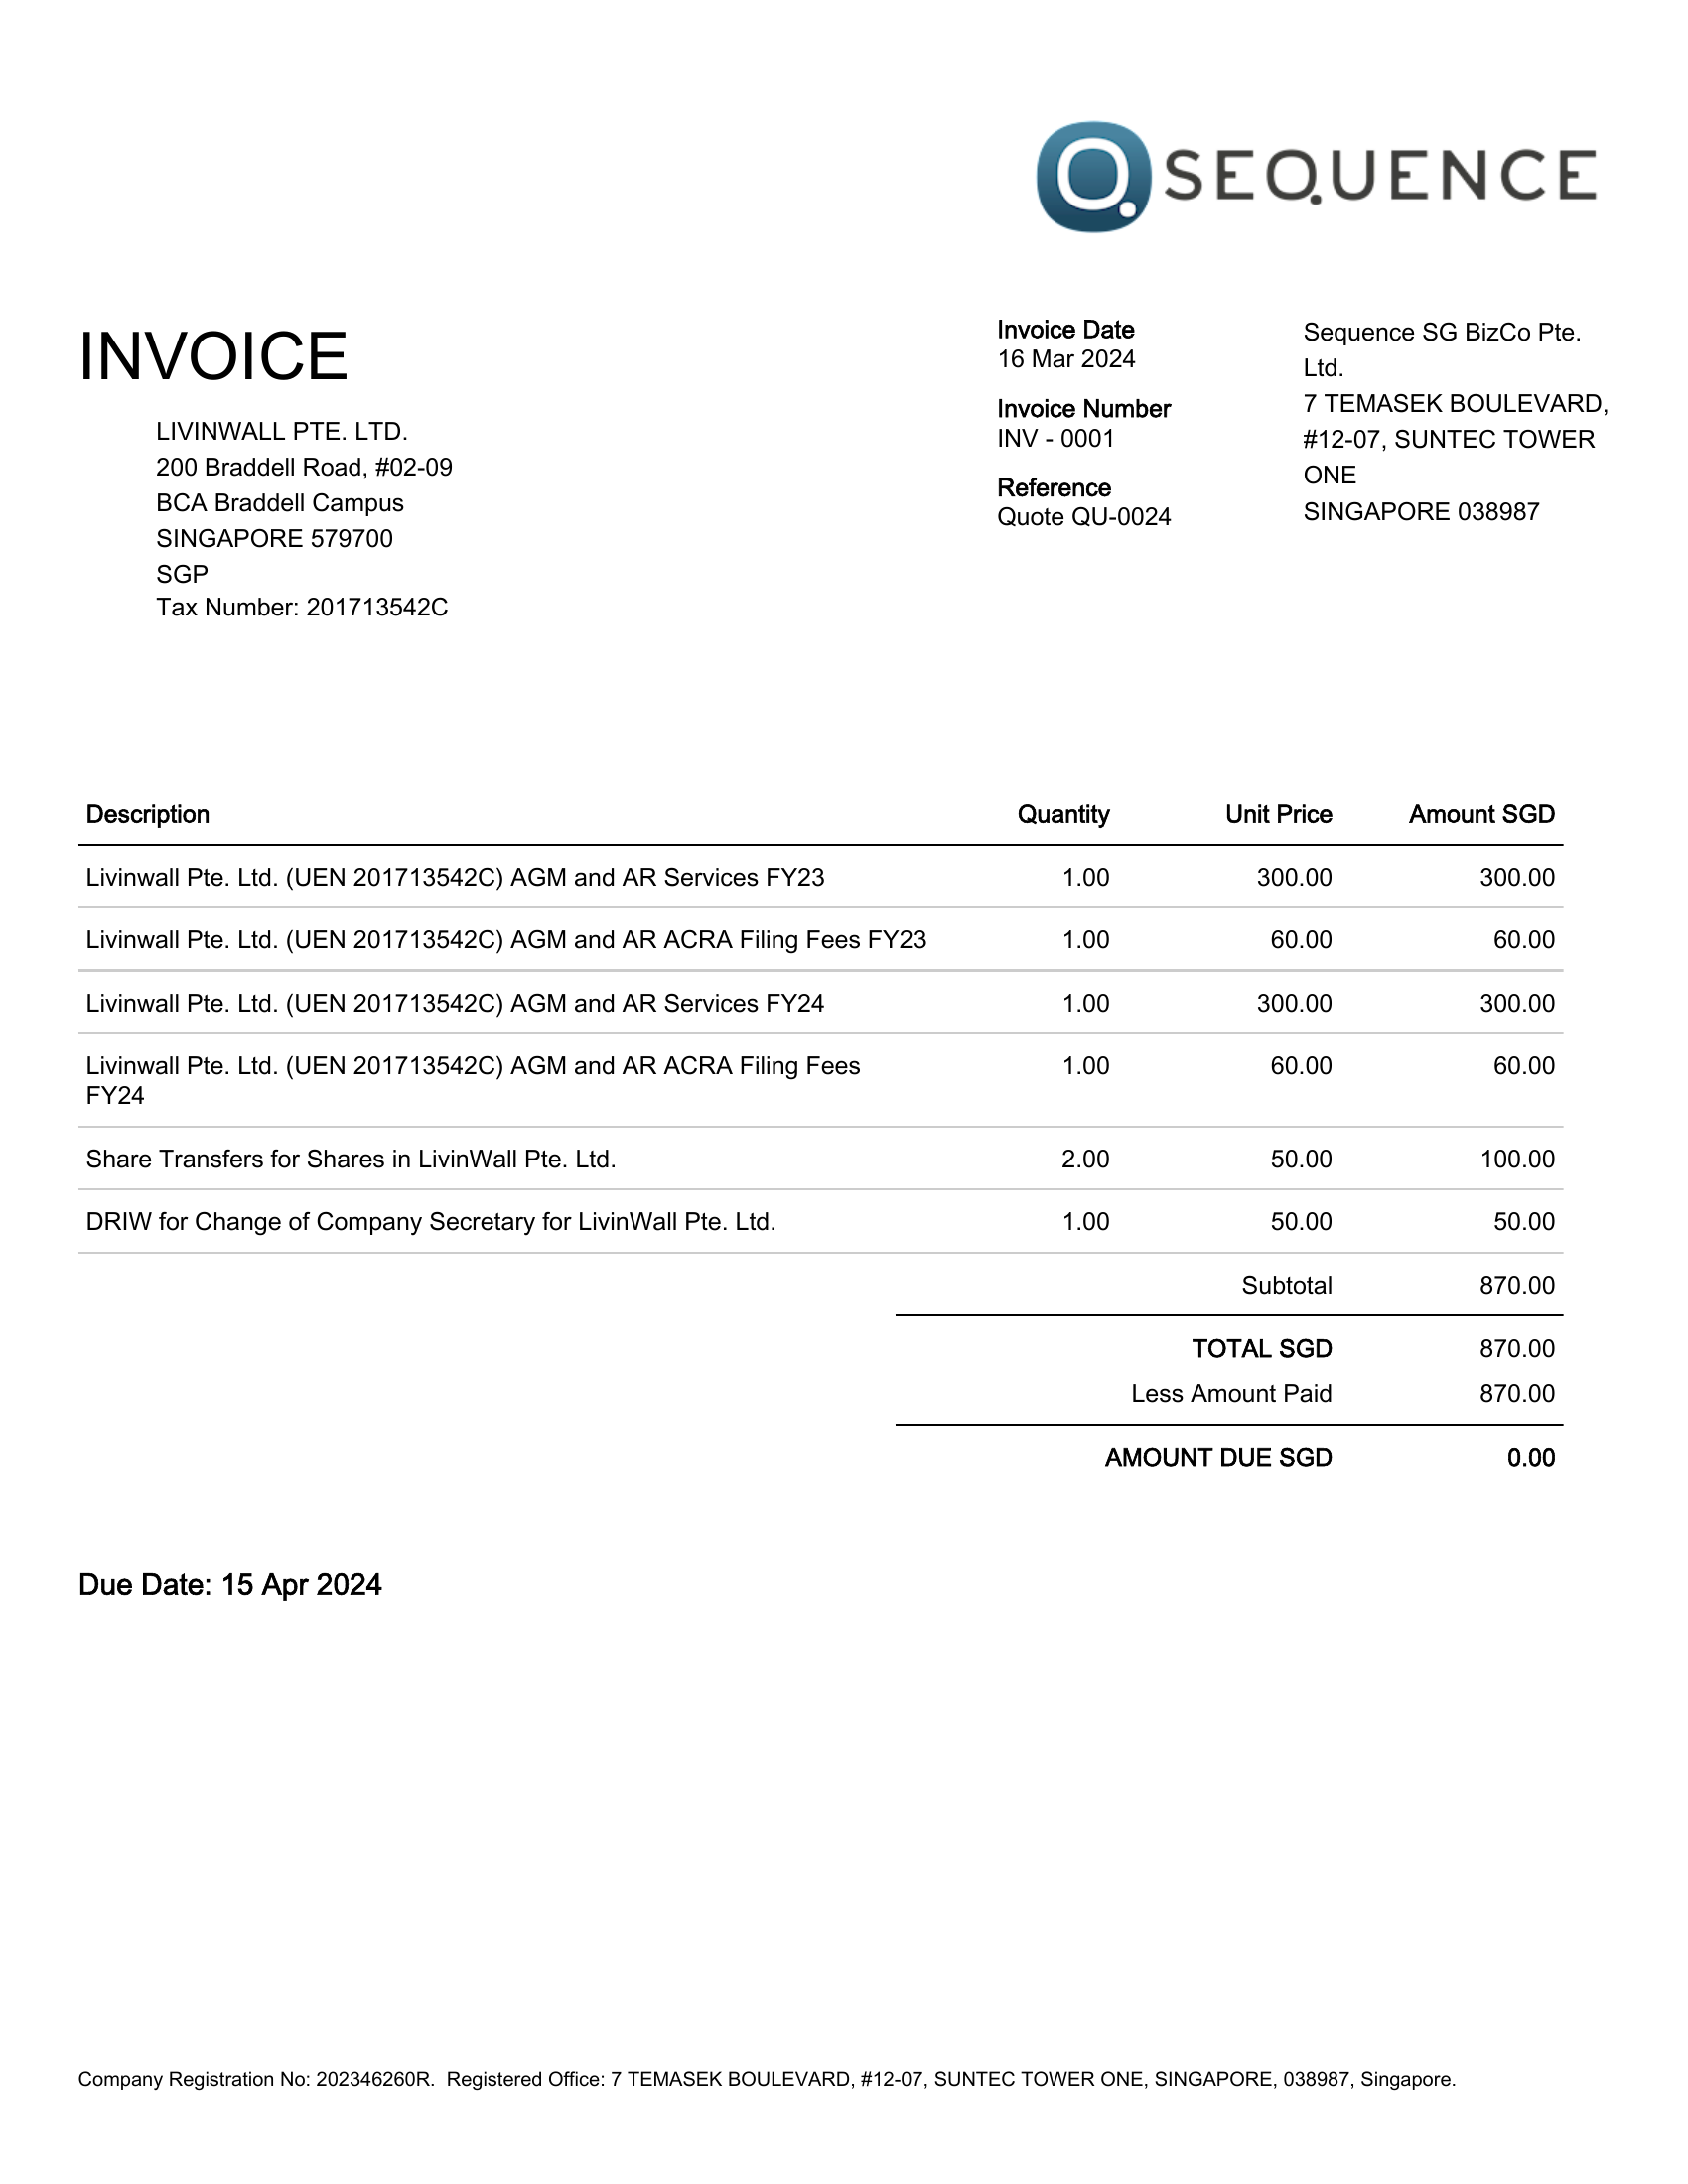

In [107]:
from PIL import Image, ImageDraw, ImageFont

#image = Image.open("/content/test_images/0011899960.png")
image = Image.open("/content/test_images/Invoice INV - 0001_1.png")
image = image.convert("RGB")
image

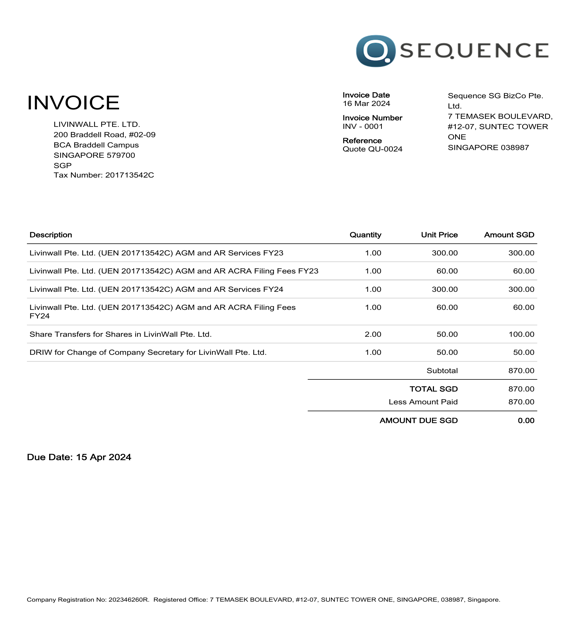

In [114]:
newimg1=image.resize((580,630))
#newimg1=image.resize((450,550))
newimg1

In [115]:
#run_inference(newimg1)
output1=run_inference(newimg1)
output1 = output1.save("/content/test1.png")

In [ ]:
!pip install PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 10.4 MB/s eta 0:00:00
